In [1]:
! ls Data
print('')
! ls Data/output/

1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepalmonitor-reports_old.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_50k_sdn_wgs84.csv
output

District_Province_Population  pop_incidents_VDC.csv
NM_2016_17clean.csv	      sources_vdc.csv


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)



#Import Main Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version for hold out set
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
7027 x 55


In [4]:
#convert 'INCIDENT DATE' column to date time objects (and limit to 2017) (and 18)
#df.index = pd.to_datetime(df.loc[:,'INCIDENT DATE'])
#df = df.loc['2017',:]

    
new_df.loc[:,'Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df.index = pd.to_datetime(new_df.loc[:,'Event Date'])
#new_df = new_df.loc['2017':'2018',:]# < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)
new_df.head()

(6630, 68)
(7027, 55)


,#,Title,Nepali Title,Event Date,Publication Date,Location,Description,Nepali Description,Tags,Latitude,...,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles,Election-related cause - primary,Election-related cause - secondary
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-11-30,21473,"Eight-year-old boy abducted, murdered","गोंगबुमा ८ वर्षीय बालकको अपहरणपछि हत्या, झोलाम...",2018-11-30,2018-11-30,"Province 3, Kathmandu",Eight-year-old boy Prayas Kunwar of Birendra-A...,काठमाडौंको गोंगबुमा ८ वर्षीय बालकको अपहरणपछि ह...,Interpersonal Violence,27.742333942136217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-28,21471,Rape accused arrested,बलात्कार घटनाका आरोपित गिरफ्तार ।,2018-11-28,2018-11-29,"Province 5, Rupandehi, Sainamaina, Ward 7",Police on Wednesday arrested 28-year-old Kesha...,१५ वर्षीया बालिकालाई बलात्कार गरेको आरोपमा प्र...,GBV\nChildren’s Rights,27.703940606896413,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-11-27,21459,Right activists stage sit-in demanding justice...,नेपालगन्जमा न्यायका लागि धर्ना।,2018-11-27,2018-11-27,"Province 5, Banke, Nepalgunj",Right activists in Nepalgunj have staged a sit...,कञ्चनपुरकी किशोरी निर्मला पन्तका हत्यारालाई का...,GBV,28.062662265656087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21460,Students padlock office of Trichandra College ...,त्रिचन्द्र कलेजमा तालाबन्दी ।,2018-11-27,2018-11-27,"Province 3, Kathmandu, Kathmandu",Students of Tri Chandra College in Kathmandu o...,शुल्क वृद्धि फिर्ता गर्न माग राख्दै आन्दोलनमा ...,Governance,27.71453911602393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,21466,Complaint lodged agaist rape accused,बलात्कार घटनाका आरोपितविरूद्ध उजुरी दर्ता,2018-11-27,2018-11-28,"Province 5, Rupandehi, Mayadevi, Ward 1",A rape complaint was filed against 30 years o...,३० वर्षीया महिलालाई बलात्कार गरेको आरोपमा माया...,GBV,27.584842280023107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


### Match (concat?_ 2017 and 2018 data
This should all be done in the data cleaning section... let's move it there afterward. 

In [6]:

#drop = ['INCIDENT NUMBER','CATEGORY','Municipality/VDC(New)','Ward(New)','Ward','Crosscutting issues','Weapon 2','Actor 2 entity name',
#        'Number of Deaths','Development Region','Number of Injuries','Verification Feedback',
#        'Event Date - Peace Monitoring','LATITUDE','LONGITUDE',
#        'VERIFIED','LOCATION','Zone','District(New)','Election-related  specific cause primary',
#        'Election-related specific cause secondary','INCIDENT DATE','INCIDENT TITLE']

new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Province','Nepali Description','Tags','Location','Latitude','Longitude']

#train_df = df.dropna(axis=1, how='all')#.sort_index(axis=1)
test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)


#train_df.drop(drop, axis=1, inplace=True)
test_df.drop(new_drop, axis=1, inplace=True)

#train_df.rename(columns={'Actor 1 Entity Name': 'Actor 1 - Entity',
                         #': 'Actor 2 - Entity',
 #                        'Actor 1 - Perpetrator Type':'Actor 1 - Affiliation',
  #                       'Perpetrator 2 - if two-sided violence':'Actor 2 - Affiliation',
   #                      'Actor 1 - Youth -25 years or below- involvement': 'Actor 1 - Youth/non-youth',
    #                     'Actor 2 - Youth -25 years or below- involvement': 'Actor 2 - Youth/non-youth',
     #                    'Actor 2 Numbers':'Actor 2 - Number of people',
                         
      #                  }, inplace=True)

#test_df = test_df.reindex(columns=['Description', 'HLCIT Code', 'Location Accuracy', 'District', 'Municipality/VDC',
 #'Source', 'Source Type', 'Duration - only applicable to non-violent forms', 
 #'Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 
 #'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 
 #'Cause - Secondary','Actor 1 - Number of people','Actor 1 - Affiliation', 'Actor 1 - Entity', 
 #'Actor 1 - Youth/non-youth', 'Actor 2 - Number of people', 'Actor 2 - Target', 'Actor 2 - Affiliation',
 #'Actor 2 - Youth/non-youth', 'Total killed', 'Female killed', 'Youth killed', 'Total injured', 'Female injured',
 #'Youth injured', 'Total raped', 'Female raped', 'Youth raped', 'Total abducted', 'Female abducted', 
 #'Youth abducted', 'Total damaged buildings', 'Severely damaged buildings', 'Total damaged vehicles', 
 #'Severely damaged vehicles'])

#train_df.sort_index(axis=1, inplace=True)
#test_df.sort_index(axis=1, inplace=True)

#print(train_df.shape,test_df.shape)

#for col in zip(train_df.columns,test_df.columns):
 #   if col[0] != col[1]:
  #      print(col)
#print(test_df.columns)

In [8]:
def strip_newline(string):
    if type(string) == str:
        return string.split('\n')[0]#.lower().replace('nonviolent', 'non-violent').strip()
    else:
        return string

def strip_paren(string):
    if type(string) == str:
        return string.split('(')[0].lower()#.replace('nonviolent', 'non-violent').replace('noyouth', 'no-youth').strip()
    else:
        return string

#get rid of extranious new lines and columns in the data    
#train_df.columns = test_df.columns
#train_df = train_df.applymap(strip_paren)
full_df = test_df.applymap(strip_newline).applymap(strip_paren)

#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df.loc[:,'Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(int)

#replacelist = ['#','District','Onesided / Twosided','Collective / Interpersonal','Actor 2 - Target', 'Actor 2 - Affiliation']
#onesided = []# <use this to place onesided and two sided
#twosided =  !='NaN']
#train_df.loc[train_df['Actor 2 - Target'] != '', 'Onesided / Twosided'] = 'onesided'
#train_df.loc[train_df['Actor 2 - Affiliation'] != '' ,'Onesided / Twosided'] = 'twosided'

#train_df.loc[:,replacelist] = train_df.loc[:,replacelist]\
#        .replace(0,'onesided').replace(1,'twosided')\
#        .replace('collective action','collective').replace('no collective action','interpersonal')
#train_df['Total killed'] = (train_df.loc[:,'Total killed'] == '1').astype(int)
#full_df.loc[:,'#'] = full_df.loc[:,'#'].astype(int)
#pd.merge(train_df[replacelist], full_df[replacelist], on='#')

#full_df['Actor 1 - Affiliation'].unique()

#you almost have it just get the expressions correct above. 

### Start with some time series analysis - predict levels of violence based on previous weeks.

In [12]:
#try and match up old and new datasets after making the dummies


#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 'Cause - Secondary', 'Actor 1 - Affiliation', 'Actor 1 - Entity', 'Actor 1 - Youth/non-youth', 'Actor 2 - Target', 'Actor 2 - Affiliation','Actor 2 - Youth/non-youth']
#full_df = full_df.applymap(strip_newline)
#incidents_date_train = pd.get_dummies(train_df, columns=dummies, dummy_na=False)#, drop_first=True)
incidents_date_test = pd.get_dummies(full_df, columns=dummies, dummy_na=False)#, drop_first=True)

#This will print something if any of the columns of the resulting dummy set are not perfectly matched.
#colist = []
#for col in incidents_date_test:
#    if col not in incidents_date_train:
#        colist.append(col)

#colist1 = []
#for col  in incidents_date_train:
#    if col not in incidents_date_test:
#        colist1.append(col)

#collists = pd.DataFrame([colist,colist1], index = ['not in old set', 'not in new set'])


#incidents_date = incidents_date_train.append(incidents_date_test)

#strip out blank dummy categories 
for col in dummies:
    badstr = col+'_'
    if badstr in incidents_date_test.columns:
        incidents_date.drop(badstr, inplace=True, axis=1)
        print('dropped useless category:', badstr)
    

in_week = incidents_date_test.resample('W').sum()
in_day = incidents_date_test.resample('D').sum()
print(in_week.shape)
print(in_day.shape)
in_week.head()
#incidents_date.head()
#incidents_date.columns
#pd.set_option('display.max_colwidth', 200)
#collists.transpose()


(101, 320)
(699, 320)


,Total killed,Female killed,Youth killed,Total injured,Female injured,Total raped,Female raped,Youth raped,Total abducted,Female abducted,...,Actor 2 - Affiliation_security forces - apf,Actor 2 - Affiliation_security forces - army,Actor 2 - Affiliation_security forces - police,Actor 2 - Affiliation_security forces - security forces,Actor 2 - Affiliation_students,Actor 2 - Affiliation_unclear,Actor 2 - Youth/non-youth_na,Actor 2 - Youth/non-youth_noyouth,Actor 2 - Youth/non-youth_unknown,Actor 2 - Youth/non-youth_youth
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2,3.0,3.0,8.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,4,1,2,4
2017-01-08,9,5.0,5.0,20.0,2.0,7.0,7.0,6.0,0.0,0.0,...,0,0,2,0,0,0,28,9,8,14
2017-01-15,11,4.0,3.0,10.0,4.0,6.0,6.0,6.0,1.0,0.0,...,0,0,0,0,0,0,20,10,7,16
2017-01-22,4,1.0,1.0,62.0,5.0,5.0,5.0,3.0,1.0,0.0,...,0,0,2,0,0,0,28,6,14,6
2017-01-29,8,1.0,5.0,34.0,3.0,10.0,10.0,7.0,1.0,0.0,...,0,0,1,0,0,0,19,11,14,15


In [13]:
#function for converting pandas time series df to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

lookback=5
time_shift_week = make_timeshift(in_week, lookback)
time_shift_day = make_timeshift(in_day, lookback)
print(time_shift_day.shape)
time_shift_day.head()

(699, 1920)


,Total killed(t-005),Female killed(t-005),Youth killed(t-005),Total injured(t-005),Female injured(t-005),Total raped(t-005),Female raped(t-005),Youth raped(t-005),Total abducted(t-005),Female abducted(t-005),...,Actor 2 - Affiliation_security forces - apf(t),Actor 2 - Affiliation_security forces - army(t),Actor 2 - Affiliation_security forces - police(t),Actor 2 - Affiliation_security forces - security forces (t),Actor 2 - Affiliation_students(t),Actor 2 - Affiliation_unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,4.0
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0
2017-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0
2017-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,3.0
2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0


### Train your predictive model on the above data frame.
For any given variable t-n represents one step back. 
try to find a way to predict everything with everything? find out which are the most acurate?
 - let's start with one. 
  - note... at some point try to preserve labels, so you know what is actually contributing. 

must create train test sets of the array above
test reserve will be this years data


In [17]:
#Create X y - also do the holdhout split (perhapse change this later so it splits based on length )
def create_X_y(df, holdpc=.25):
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':].iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)


holdout_y_week.head()

(525, 1600)
(525, 320)
(174, 1600)
(174, 320)
(76, 1600)
(76, 320)
(25, 1600)
(25, 320)


,Total killed(t),Female killed(t),Youth killed(t),Total injured(t),Female injured(t),Total raped(t),Female raped(t),Youth raped(t),Total abducted(t),Female abducted(t),...,Actor 2 - Affiliation_security forces - apf(t),Actor 2 - Affiliation_security forces - army(t),Actor 2 - Affiliation_security forces - police(t),Actor 2 - Affiliation_security forces - security forces (t),Actor 2 - Affiliation_students(t),Actor 2 - Affiliation_unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-06-17,11,7.0,7.0,60.0,8.0,19.0,13.0,16.0,1.0,1.0,...,0,0,6,0,0,0,25,18,14,25
2018-06-24,10,7.0,6.0,11.0,1.0,9.0,9.0,6.0,1.0,0.0,...,0,0,1,0,0,0,11,12,6,15
2018-07-01,13,5.0,4.0,13.0,3.0,9.0,9.0,5.0,0.0,0.0,...,0,0,1,0,0,0,23,14,6,14
2018-07-08,7,4.0,2.0,8.0,3.0,17.0,17.0,15.0,0.0,0.0,...,0,0,1,0,0,0,17,10,5,20
2018-07-15,11,9.0,7.0,27.0,9.0,20.0,20.0,14.0,1.0,0.0,...,0,0,1,0,0,0,29,16,9,24


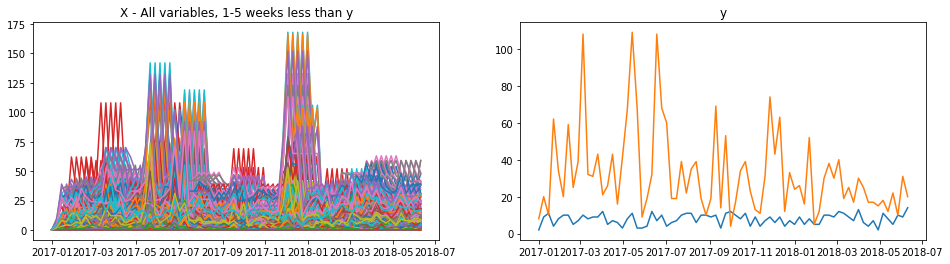

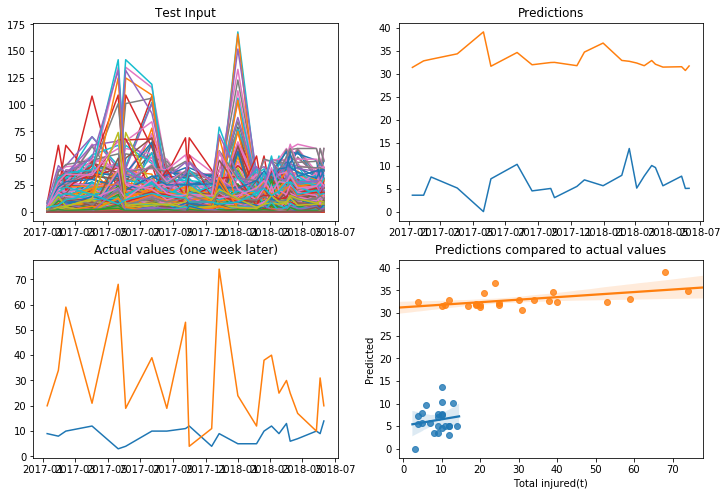

total train score: 0.538952339415
total test score: -0.631045696339
top score r_2: 0.0773975105657
top score ev: 0.101598573342


In [18]:
#Train and test a model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import check_cv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
#from sklearn.metrics import balanced_accuracy_score

#create imputer for nan values 
imp = Imputer(missing_values='NaN', strategy = 'mean')

def plot_model(X_test, y_test, y_pred):
    sync = pd.DataFrame(y_pred, index=y_test.index) #index=y_test.index)
    #print(sync.head())    
        
    f, (ax0, ax1) = plt.subplots(2,2, figsize=(12,8))
    ax0[0].plot(X_test.sort_index())
    ax0[0].set_title('Test Input')
    ax0[1].plot(sync.sort_index())
    ax0[1].set_title('Predictions')
    ax1[0].plot(y_test.sort_index())
    ax1[0].set_title('Actual values (one week later)')
    
    for var in range(y_test.shape[1]):
        sns.regplot(y_test.iloc[:,var], sync.iloc[:,var], ax=ax1[1])
    ax1[1].set_title('Predictions compared to actual values')
    ax1[1].set_ylabel('Predicted')
    ax1[0].legend()
    plt.show()

    
def test_model(X_train, X_test, y_train, model):
    #fit the model to the training set
    model.fit(X_train, y_train)

    #predict outcomes beased on training set
    y_pred = model.predict(X_test)
    
    return y_pred, model

def score_model(X_train, X_test, y_train, y_test, y_pred, model, verbose=False):
    
    #score model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values') #
    ev = explained_variance_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')    
    try:
        cm = confusion_matrix(y_test, y_pred)
        #bal_acur = balanced_accuracy_score(y_test, y_pred)
        #to handle linear models, will just score with r_2
    except:
        cm = np.array([0,0,0])     
    
    if verbose > 0:
        #Plot what these look like
        plot_model(X_test, y_test, y_pred)
    
    return train_score, test_score, r_2, ev, cm, 

    
#create fuction to train model and find a variable than can be predicted from the previous week's data
def try_model(X, y, model, verbose=0, random_state=None):


    #Split X and Y into training and testing sets... #we'll use this years data as the hold out set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle=True, random_state=random_state)
    #print(y_test.head())
    
    #use function above to train model and create predictions
    y_pred, model = test_model(X_train, X_test, y_train, model)
    
    #bandaid to set negative predictions to 0
    y_pred[y_pred < 0] = 0
                                   
    #use function above to score the model based on predictions
    train_score, test_score, r_2, ev, cm,  = score_model(X_train, X_test, y_train, y_test, y_pred, model, verbose=verbose)
    
    
    if verbose > 0:
        #print scores
        print('total train score:', train_score )
        print('total test score:', test_score)
        print('top score r_2:',r_2.max())
        print('top score ev:',ev.max())
        #print('R2 score:', r_2) 
        #print('explained variance', ev)
        #print('confusion matrix\n',cm)#n,p\nn', cm[0],'\np',cm[1])
        #if cv_done == True:
        #    print('crossvalidation mean:',cv_score.mean(), cv_score)
        #else:
        #    print('Initial test score not promissing. No crossvalidation')
        #print('Top Feature Probabilities:', log_proba.sort_values(1, axis=1, ascending=False))
        #print('Bottom Feature Probabilities:', bottom_prob)
    
  
       
    return train_score, test_score, r_2, ev#, coef

#define y
y = y_week.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

#Plot what X and y look like
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(X_week)
ax1.set_title('X - All variables, 1-{} weeks less than y'.format(int(lookback)))
ax2.plot(y)
ax2.set_title('y')
plt.show()

#give the function to try the model a dry run
dry_run = try_model(X_week, y, MultiOutputRegressor(BayesianRidge(), n_jobs=20), verbose = 2)


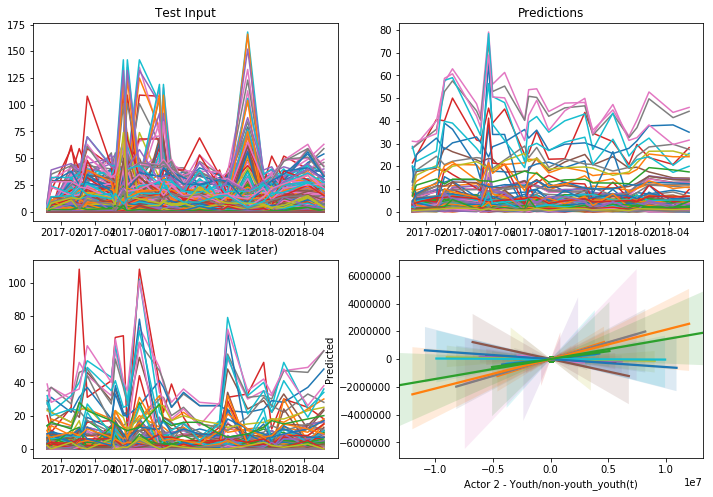

total train score: 0.845083712353
total test score: -0.243889937477
top score r_2: 0.311866125761
top score ev: 0.324290060852


/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


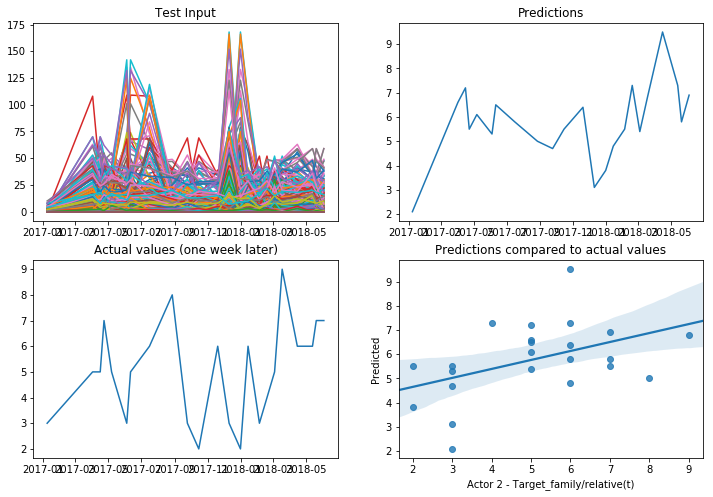

total train score: 0.84675878965
total test score: -0.0594575725027
top score r_2: -0.0594575725027
top score ev: 0.0939312567132


,r_2,explained_variance
Actor 2 - Target_family/relative(t),0.311866,0.32429
Actor 1 - Affiliation_family/relative(t),0.298934,0.304352
Event Form - Primary_violent - group clash(t),0.185738,0.269526
Actor 2 - Target_political organization/politician - uml and affiliated org(t),0.250191,0.268263
Female injured(t),0.14654,0.248615
Actor 1 - Youth/non-youth_noyouth(t),0.229945,0.247673
Weapons_none(t),0.189145,0.228272
"Actor 1 - Affiliation_health sector/health workers, doctors(t)",0.179471,0.219781
Onesided / Twosided_twosided(t),0.0802284,0.211382
Actor 2 - Affiliation_political organization/politician - uml and affiliated org(t),0.20436,0.210911


In [28]:
#find which variables have the best crossvalidation scores
def find_var (X, df, model, n_true, verbose=False, random_state=None):
    scores = pd.DataFrame(index=df.columns, columns=['r_2','explained_variance'])
    #for var in df.columns:
    #y = df# > df[var].quantile(.5)
    #X = time_shift.loc[:,'var1(t-1)':'var340(t-1)']
    #n_class = y.nunique()
    #n_bins = 10
    #n_true = 10
    pc_true = [sum(df[x] >= 1)/len(df[x])*100 > n_true for x in df.columns]
    #flt = 
    y = df.loc[:,pc_true] #make it a percentage
        #if verbose == True:
         #   print('\n')
          #  print(var)
        #if verbose == False:
         #       print('.', end='')
        
      
    train_score, test_score, r_2, ev = try_model(X, y, model, verbose = verbose, random_state=random_state)
            
     #scores.loc[var,'cv_mean'] = cv_score.mean()
    #scores.loc[:,'train_score'] = train_score
    #scores.loc[:,'test_score'] = test_score
    #scores.loc['pc_true'] = pc_true   
    scores.loc[pc_true,'r_2'] = r_2
    scores.loc[pc_true,'explained_variance'] = ev
            #scores.loc[var,'confusion_matrix'] = cm
            #print(scores[var])
    
    #print('bing!')
    
    return scores
#for step in range(5,y_week.shape[1])[::5]:
#model = MultiOutputRegressor(BayesianRidge(normalize=False), n_jobs=20)
model = RandomForestRegressor(random_state=None)

scores = find_var(X_week, y_week, model, n_true=20, verbose=2, random_state=None)
top = scores.sort_values('explained_variance', ascending=False)[:20]
top_score = find_var(X_week, y_week.loc[:,top.index[:1]], model, n_true=20, verbose=2, random_state=None)
top

In [47]:
def interpet_prob(log_proba):
    pd.set_option('display.max_colwidth', 200)
    print(np.exp(log_proba).sort_values(0)[:2])
    print(np.exp(log_proba).sort_values(1)[:2])
    sns.heatmap(np.exp(log_proba).sort_values(1))
    plt.show()

def investigate(cats, X_train, y_train, holdout_X, holdout_y, model, verbose=0, random_state=None):
    #function to look futher into better performing results
    holdout_scores = pd.DataFrame(index=cats, columns=['r_2', 'explained_variance'])
    #for cat in cats:
    y = y_train[cats]# > y_train[cat].quantile(.5)
    if verbose > 0:
        #print('\n',y_train[cats].columns,':')
        train_score, test_score, r_2, ev = try_model(X_train, y, model, verbose = 2, random_state=random_state)
            #interpet_prob(coef)
    
    h_y = holdout_y[cats]# > holdout_y[cat].quantile(.5)
    y_pred, model = test_model(X_train, holdout_X, y, model)
    train_score, test_score, r_2, ev, cm = score_model(X_train, holdout_X, y, h_y, y_pred, model)
    if verbose > 0:
        plot_model(holdout_X, h_y, y_pred)
        #scores = score_model(X_train, holdout_X, y, h_y, y_pred, model)
        #holdout_scores.loc[cat,['train_score', 'test_score', 'confusion_matrix', 'r_2']] = scores
        #holdout_scores.loc[cat,'train_score'] = train_score
        #holdout_scores.loc[cat,'test_score'] = test_score
        #holdout_scores.loc[cat,'confusion_matrix'] = cm
    holdout_scores.loc[cats,'r_2'] = r_2
    holdout_scores.loc[cats,'explained_variance'] = ev
    return holdout_scores


In [48]:
#create function to optimize lookback!
import random

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)#need to
    
    #generate a random state for consistent comparisons
    random_state = random.randint(1,1000)
    print('using random_state:', random_state)
    #loop through possible ranges to look back at to find the the optimum value
   
    for lookback in (range(1,50)):
        
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #bandaid fix
        scoredf.index = y.columns.tolist()
        
        #find the scores for all the variables #(those which have more positives than negatives)
        scores = find_var(X, y, model, n_true=50, verbose=0, random_state=random_state)
        
        #print(scores.head())
        #find the sum of the crossvalidation scores
        #test = np.sum(scores['cv_mean'])
        
        
        #find which variables recieved a score above 0
        top_scores = scores.loc[scores['explained_variance'] > 0].index.tolist()
        #print(top_scores)
        
        #find sum of scores above 0
        top_sum = np.sum(scores.loc[top_scores,'explained_variance'])
        
        #use investigate function to see how those variables did against the holdout set
        holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=False, random_state=random_state)             
        #print(holdout_scores.head())
        
        #find the sum of the hold out test scores scores
        holdout_max = np.max(holdout_scores.loc[:,'explained_variance'])
        #print(holdout_sum)
        
        #print the lookback interval, and mean scores
        print('\nt-{0} top sum: {1:.2f}, holdout_max: {2:.2f} '.format(lookback,top_sum, holdout_max))
        
        #append the crossvalidation score to the list
        scorelist.append(top_sum)#(cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='left', sort=False, rsuffix=('(t-'+str(lookback).zfill(3)+')'))
        scoredf = scoredf.join(holdout_scores, how='left', sort=False, rsuffix='_holdout(t-'+str(lookback).zfill(3)+')')
        #scoredf = pd.concat([scoredf, scores, holdout_scores], axis=1, join_axes=[scoredf.index])
        
        #stop fuction and return scores soon as there is a definate downward trend
        if len(scorelist) > 10:
            if np.median(scorelist[-5:]) < np.median(scorelist[-10:-5]):
                return scoredf


model = RandomForestRegressor()
#scoredf_day = opt_lookback(in_day, BayesianRidge())
scoredf_week = opt_lookback(in_week, model)
print('bing!')

scoredf_week.head()
#plt.plot(scoredf_day)#, label = 'by day')
#plt.plot(scoredf_week, label = 'by week')
#plt.title('Mean crossvalidation scores v. lookback times')
#plt.legend()
#plt.show()

Optimizing...
using random_state: 444

t-1 top sum: 6.20, holdout_max: 0.35 

t-2 top sum: 8.52, holdout_max: 0.15 

t-3 top sum: 5.58, holdout_max: 0.20 

t-4 top sum: 8.29, holdout_max: 0.25 

t-5 top sum: 5.11, holdout_max: 0.26 

t-6 top sum: 5.74, holdout_max: 0.31 

t-7 top sum: 6.21, holdout_max: 0.21 

t-8 top sum: 10.18, holdout_max: 0.32 

t-9 top sum: 4.73, holdout_max: 0.22 

t-10 top sum: 2.89, holdout_max: 0.21 

t-11 top sum: 4.63, holdout_max: 0.19 
bing!


,r_2,explained_variance,r_2_holdout(t-001),explained_variance_holdout(t-001),r_2(t-002),explained_variance(t-002),r_2_holdout(t-002),explained_variance_holdout(t-002),r_2(t-003),explained_variance(t-003),...,r_2_holdout(t-009),explained_variance_holdout(t-009),r_2(t-010),explained_variance(t-010),r_2_holdout(t-010),explained_variance_holdout(t-010),r_2(t-011),explained_variance(t-011),r_2_holdout(t-011),explained_variance_holdout(t-011)
Total killed(t),0.0803893,0.0986896,-0.0951806,0.0162335,-0.343576,-0.243941,NaN,NaN,0.0552539,0.136223,...,-0.29101,-0.028909,-0.337181,-0.246185,NaN,NaN,0.284642,0.284797,-0.489287,-0.119855
Female killed(t),0.263924,0.265159,-0.00777249,-0.00747623,-0.116422,-0.0776948,NaN,NaN,-0.0413117,-0.0329638,...,NaN,NaN,0.0136004,0.0242261,-0.0526701,-0.0268617,0.0514709,0.0712294,-0.0408742,-0.0408413
Youth killed(t),-0.072126,-0.0588819,NaN,NaN,-0.0991102,-0.0858661,NaN,NaN,0.0416063,0.0416063,...,NaN,NaN,-0.0127244,-0.00703937,NaN,NaN,0.0157087,0.0384488,-0.20103,0.0154539
Total injured(t),0.00273145,0.0030279,0.0359702,0.210892,0.0401937,0.0675392,-0.290687,0.000954979,0.0231805,0.0311897,...,-0.153297,0.0175574,-0.17245,-0.125106,NaN,NaN,-0.0981594,-0.0924316,NaN,NaN
Female injured(t),-0.060264,0.00591466,-0.123643,-0.105774,-0.210002,-0.0683016,NaN,NaN,-0.200917,-0.152112,...,NaN,NaN,-0.251153,-0.16834,NaN,NaN,0.130188,0.164259,-0.0908286,-0.0425543


In [43]:
#scoredf_week.head() #0,1,2,3, <- variables to plot

In [44]:
#scoredf_week['cv_mean'].sum()
#scoredf_week.iloc[:,::4]

week


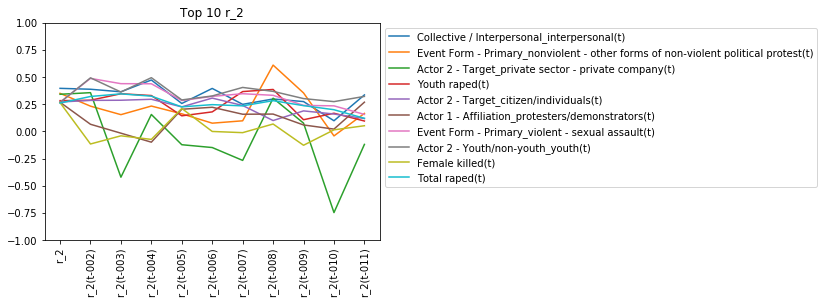

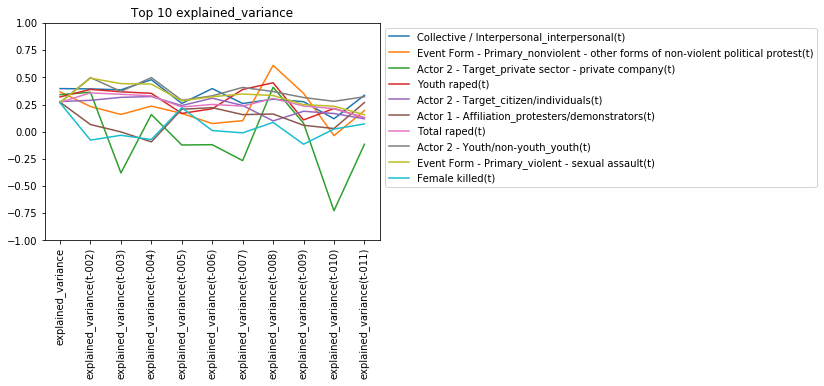

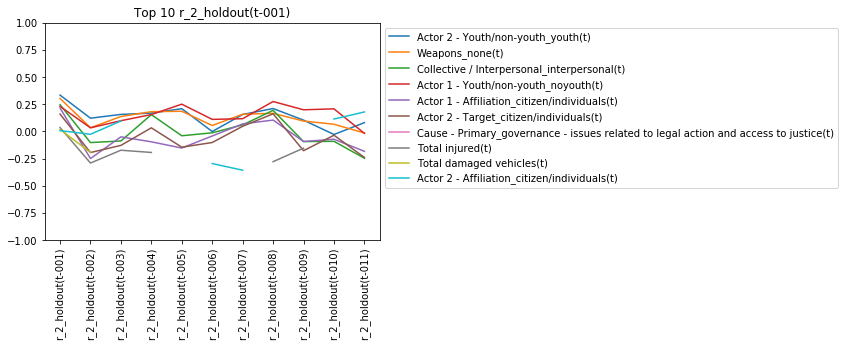

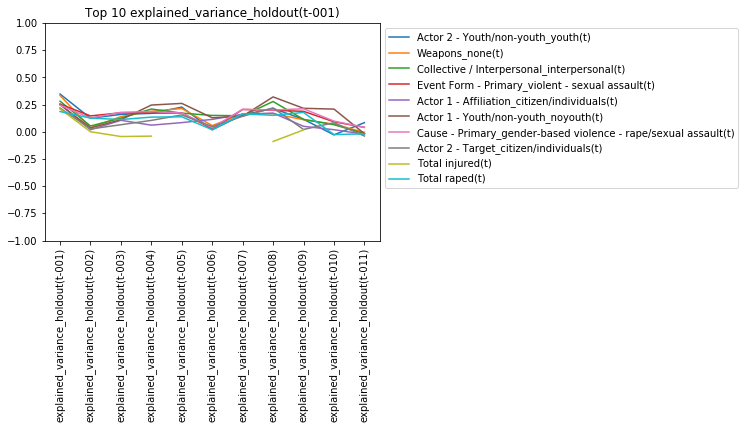

In [49]:
def plot_frame(df, start):
    plotvar = df.iloc[:,start::4].sort_values(df.columns[start::4].tolist(), axis=0, ascending=False)[:10]
    #sortvar = plotvar.sort_index(axis=1, ascending=False)
    for label in plotvar.index:
        plt.plot(plotvar.loc[label,:], label=label)

    plt.xticks(rotation=90)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Top 10 '+plotvar.columns[0])
    plt.show()
    #print(plotvar)

#print('day')
#for start in [0,1,3,5,7]:
    #plot_frame(scoredf_day, start)

print('week')
for start in [0,1,2,3]:
    plot_frame(scoredf_week, start)
    


In [ ]:
scoredf_week.sort_values('test_score_holdout(t-009)', ascending=False)

In [ ]:
#plt.plot(scorelist_day, label = 'by day')
#plt.plot(scorelist_week, label = 'by week')
#plt.title('Mean crossvalidation scores v. lookback times')
#plt.legend()
#plt.show()
#scoredf_day
#plt.plot()

#plt.show()
#scoredf_day.loc[:,::4]
plt.plot(scoredf_day.iloc[:,0::7].sort_values('cv_mean(t-3)')[:10], marker='.', linestyle='none')
plt.xticks(rotation=90)
plt.show()

Note effectiveness of MultinomialNB() at predicting demonstrations and sit ins / collective violence based on indicators from the previous weeks. Indicators that ... and testing on the hold out set of this years data.

Perhaps proceed with dialing in collective violence. 

In [ ]:
#Dial in communal violence predictions


In [ ]:
cv_scores_day = find_var(X_day, in_day, MultinomialNB(), n_true=20, verbose=False)
top10_day = cv_scores_day.sort_values('cv_mean', ascending=False)[:10]
top10_day

In [ ]:
for cat in top10_day.index:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, MultinomialNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X_day, y, MultinomialNB(), verbose = 2)
        interpet_prob(log_proba)

In [193]:
from sklearn.naive_bayes import BernoulliNB

BNB_scores = find_var(X, in_week, BernoulliNB(), n_true=20, verbose=False)
BNB_top10 = BNB_scores.sort_values('cv_mean', ascending=False)[:10]
BNB_top10

scoreBNBdf_week = opt_lookback(in_week, MultinomialNB())

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bing!


,cv_mean,test_score,confusion_matrix,pc_true
"Crosscutting issues_Constitutional Process,Local Body Restructuring",0.830065,0.875,"[[10, 1], [1, 4]]",22.6415
Target - if one-sided violence_Group of civilians (only Target) (1701),0.755991,0.9375,"[[14, 0], [1, 1]]",20.7547
Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404),0.755418,0.9375,"[[12, 1], [0, 3]]",24.5283
Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election,0.754902,0.875,"[[13, 0], [2, 1]]",22.6415
"Crosscutting issues_Elections,Constitutional Process",0.736383,0.9375,"[[12, 0], [1, 3]]",22.6415
Cause - secondary_ (),7.90505e-323,0.6875,"[[11, 0], [5, 0]]",24.5283
Actor 1 - Perpetrator Type_Criminal (1401),7.90505e-323,0.75,"[[12, 0], [4, 0]]",24.5283
Actor 1 - Perpetrator Type_Citizen/Individuals (2001),7.90505e-323,0.8125,"[[13, 0], [3, 0]]",20.7547
Crosscutting issues_GBV,7.90505e-323,0.875,"[[14, 0], [2, 0]]",20.7547
Crosscutting issues_Elections,7.90505e-323,0.8125,"[[13, 0], [3, 0]]",24.5283


In [60]:
scoreBNBdf_week = opt_lookback(in_week, MultinomialNB())

Optimizing...
..................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


..................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


........................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


.................................................................................................................................................................
t-1 mean_cv sum: 10.54, holdout_mean sum: 2.57 
.................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


............................................................................................................................................................................................................................................................................................................................................
t-2 mean_cv sum: 7.32, holdout_mean sum: 2.96 
...............

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...........................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...................................................................................................................................................................................................................................................................................................................
t-3 mean_cv sum: 8.78, holdout_mean sum: 3.04 
.........................................................................................................................................................................................................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


....................................
t-4 mean_cv sum: 9.80, holdout_mean sum: 4.26 
..................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...........................................................................................................................................................................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars



t-5 mean_cv sum: 6.99, holdout_mean sum: 2.17 
..............................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


............................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...................................................................................................................................................................................................................................................................
t-6 mean_cv sum: 6.20, holdout_mean sum: 1.13 
...............

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


............................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


..........................................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


........................................................................................................................................................
t-7 mean_cv sum: 11.80, holdout_mean sum: 4.61 
......................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars
/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


........................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...............................................................................................................................................................................................................................................................................
t-8 mean_cv sum: 10.08, holdout_mean sum: 4.04 
..................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


.................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


.......................................................................................
t-9 mean_cv sum: 8.26, holdout_mean sum: 2.91 
.............................................................................................................................................................................................................................................................................................................................................................................................
t-10 mean_cv sum: 8.87, holdout_mean sum: 4.09 
.................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


.................................................................................................................................................................................................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...........................................................................................................
t-11 mean_cv sum: 6.16, holdout_mean sum: 4.26 
..........................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


...................................................................................................................................................................................................................................................................................................................
t-12 mean_cv sum: 9.18, holdout_mean sum: 4.13 
.................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in long_scalars


..................................................................

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


..........................................................................................................................................................................................................................................................................................
t-13 mean_cv sum: 5.82, holdout_mean sum: 1.83 


In [228]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_week[cat] > in_week[cat].quantile(.75)
    cv_score, test_score, cm, log_proba = try_model(X, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [230]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
rgs = RandomForestRegressor()
cls = RandomForestClassifier()
#y = 
#try_model(X, y, cls)

In [65]:
clsdf_week = opt_lookback(in_week, rgs)

Optimizing...
.

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_log_proba'

In [ ]:
top6 = cv_scores.sort_values('cv_mean', ascending=False)[:6]
top6

In [ ]:
s2 = pd.Series([6,8,3], index=list('abc'))
s4 = pd.Series([1,2,3], index=list('abc'))

s2 + s4